In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [3]:
# Y_true

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

D:\Installation\Anaconda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
D:\Installation\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [17]:
def plt_dynamic(x,vy,ty,ax,color=['b']):
    ax.plot(x,vy,'b',label='validation accuracy')
    ax.plot(x,ty,'r',label='Train accuracy')
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [19]:
# Initiliazing the sequential model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten

- Defining the Architecture of LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

W0915 23:28:22.933180 20020 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 23:28:22.937182 20020 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0915 23:28:22.954177 20020 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0915 23:28:26.757184 20020 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0915 23:28:27.263177 20020 deprecation.py:506

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0915 23:28:35.733438 20020 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0915 23:28:36.121435 20020 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



In [ ]:
# # Training the model
# model.fit(X_train,
#           Y_train,
#           batch_size=batch_size,
#           validation_data=(X_test, Y_test),
#           epochs=epochs)

W0915 23:28:40.946323 20020 deprecation.py:323] From D:\Installation\Anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 312s 42ms/step - loss: 1.3175 - acc: 0.4342 - val_loss: 1.1708 - val_acc: 0.4669
Epoch 2/30
7352/7352 [==============================] - 249s 34ms/step - loss: 0.9981 - acc: 0.5650 - val_loss: 0.9204 - val_acc: 0.5955
Epoch 3/30
7352/7352 [==============================] - 218s 30ms/step - loss: 0.8183 - acc: 0.6457 - val_loss: 0.7762 - val_acc: 0.6125
Epoch 4/30
7352/7352 [==============================] - 182s 25ms/step - loss: 0.7169 - acc: 0.6597 - val_loss: 0.7144 - val_acc: 0.6179
Epoch 5/30
7352/7352 [==============================] - 200s 27ms/step - loss: 0.6478 - acc: 0.6786 - val_loss: 0.7208 - val_acc: 0.6210
Epoch 6/30
7352/7352 [==============================] - 213s 29ms/step - loss: 0.6107 - acc: 0.6881 - val_loss: 0.7159 - val_acc: 0.6359
Epoch 7/30
7352/7352 [==============================] - 250s 34ms/step - loss: 0.5629 - acc: 0.7146 - val_loss: 0.6832 - val_acc: 

In [ ]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

In [ ]:
score = model.evaluate(X_test, Y_test)

In [ ]:
score

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

### Creating the first class classifier

In [ ]:
X_train[0]

In [ ]:
X_train.shape

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# # estimator_arr_param = [100, 200, 250, 300]
# # depth_arr_param = [2, 5, 10]
# clf = RandomForestClassifier(n_estimators=100, max_depth=3, criterion='gini')
    
# clf.fit(X_train, Y_train)
# y_train_pred = batch_predict(clf, X_train)
# y_test_pred = batch_predict(clf, X_test)

In [ ]:
print(len(X_train))
print(len(X_train[0]))
print(len(X_train[0][0]))

In [ ]:
len(Y_train)

In [ ]:
len(X_train.shape)

In [17]:
print(len(X_train[0]))
print(len(X_train[0][0]))
# print(len(X_train[0][0][0]))
print(X_train.shape)
print("*"*10)
print(timesteps)
print(input_dim)

128
9
(7352, 128, 9)
**********
128
9


In [18]:
Y_train

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [24]:
from numpy import newaxis
X_train_new = X_train[:,:,:, newaxis]
print(X_train_new.shape)
X_test_new = X_test[:,:,:, newaxis]
print(X_test_new.shape)

(7352, 128, 9, 1)
(2947, 128, 9, 1)


In [22]:
# Y_train_new_d

In [23]:
# Initiliazing the sequential model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
model = Sequential()

model.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
model.add(Dropout(0.3))
model.add(Flatten())

model.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model.add(Dense(6, activation='softmax', name="dense_1"))
print(model.summary())

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model
model.fit(X_train_new,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test_new, Y_test),
          epochs=15)

loss = model.evaluate(X_test_new,
          Y_test)
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28224)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 169350    
Total params: 282,566
Trainable params: 226,118
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 

Checking the accuracy of the model where it is lagging.

In [44]:

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [46]:
# import seaborn as sn
# import matplotlib.pyplot as plt
# sn.heatmap(confusion_matrix(Y_test, model.predict(X_test_new)), annot=True, cmap="YlGnBu")
# plt.show()
# # print(confusion_matrix(Y_test, model.predict(X_test_new)))

##### confusion arose in between: laying sitting standing
##### confusion arose in between: walking walkupstairs, walkdownstairs


# 2 stage classification

## Binary Class classifier

Dynamic: Walk, Walk Upstairs, Walk Downstairs <br>
Static: Stand, Sit, Lay

where we can pick Y's calsses

    1. Walking     
    2. WalkingUpstairs 
    3. WalkingDownstairs 
    4. Standing 
    5. Sitting 
    6. Lying.


In [25]:
Y_binary_train=[]
Y_binary_test=[]

for arr in Y_train:
    #     print(val, end="|")
    if arr[0] ==1 or arr[1]==1 or arr[2]==1:
        Y_binary_train.append(1)
    else:
        Y_binary_train.append(0)
        
for arr in Y_test:
    #     print(val, end="|")
    if arr[0] ==1 or arr[1]==1 or arr[2]==1:
        Y_binary_test.append(1)
    else:
        Y_binary_test.append(0)
        

print(len(Y_binary_train))
print(len(Y_binary_test))


7352
2947


In [26]:
# Initiliazing the sequential binary_model_1
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
binary_model_1 = Sequential()

binary_model_1.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# Adding a dropout layer
binary_model_1.add(Dropout(0.3))
binary_model_1.add(Flatten())

binary_model_1.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
binary_model_1.add(Dense(1, activation='sigmoid', name="dense_1"))
print(binary_model_1.summary())

# Compiling the binary_model_1
binary_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the binary_model_1
binary_model_1.fit(X_train_new,
          Y_binary_train,
          batch_size=batch_size,
          validation_data=(X_test_new, Y_binary_test),
          epochs=15)

loss = binary_model_1.evaluate(X_test_new,
          Y_binary_test)
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_6 (Dropout)          (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28224)             0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 28225     
Total params: 141,441
Trainable params: 84,993
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 2

In [29]:
# Initiliazing the sequential binary_model_1
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
binary_model_1 = Sequential()

binary_model_1.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# Adding a dropout layer
binary_model_1.add(Dropout(0.3))
binary_model_1.add(Flatten())

binary_model_1.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
binary_model_1.add(Dense(1, activation='sigmoid', name="dense_1"))
print(binary_model_1.summary())

# Compiling the binary_model_1
binary_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the binary_model_1
binary_model_1.fit(X_train_new,
          Y_binary_train,
          batch_size=batch_size,
          validation_data=(X_test_new, Y_binary_test),
          epochs=10)

loss = binary_model_1.evaluate(X_test_new,
          Y_binary_test)
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_7 (Dropout)          (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 28224)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 28225     
Total params: 141,441
Trainable params: 84,993
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 2

In [31]:
y_hat_binary_test = binary_model_1.predict_classes(X_test_new)
y_hat_binary_train = binary_model_1.predict_classes(X_train_new)

# ans = [1 if ele[0]>=0.1 else 0 for ele in y_hat_binary]
# ans

In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_binary_test, y_hat_binary_test))
print(confusion_matrix(Y_binary_train, y_hat_binary_train))
# len(y_hat_binary_train)

[[1558    2]
 [   1 1386]]
[[4067    0]
 [   4 3281]]


In [33]:
arr = [1,2,3,4,5,6]
arr1 = arr[:3]
arr2=arr[3:]
print(arr1)
print(arr2)


[1, 2, 3]
[4, 5, 6]


In [34]:
for arr in Y_train:
    Y_train_d=  arr[:3]
    Y_train_s=  arr[3:]
    

In [35]:
print(X_train_new.shape)
print(X_test_new.shape)
print(Y_train.shape)
print(Y_test.shape)

(7352, 128, 9, 1)
(2947, 128, 9, 1)
(7352, 6)
(2947, 6)


### Taking help of predicted value from model1 to divide it into static and dynamic data

In [33]:
# y_hat_binary

NameError: name 'y_hat_binary' is not defined

In [ ]:
# y_hat_binary#[0][0]

In [ ]:
# for val in 

In [36]:
X_train_new_d = []
Y_train_new_d = []
X_train_new_s = []
Y_train_new_s = []

for ind, val in enumerate(y_hat_binary_train): #<------------- we are using ans to divide the data
    if val[0] == 1:
        X_train_new_d.append(X_train_new[ind])
        Y_train_new_d.append(list(Y_train[ind][:3]))
#         print(Y_train[ind], "||d||strt3|||", Y_train[ind][:3])
        if max(Y_train[ind][:3])==0: print("Misclassified")
    else:
        X_train_new_s.append(X_train_new[ind])
        Y_train_new_s.append(list(Y_train[ind][3:]))
#         print(Y_train[ind], "||s||end 3|||", Y_train[ind][3:])
        if max(Y_train[ind][3:])==0: print("Misclassified")

X_test_new_d = []
Y_test_new_d = []
X_test_new_s = []
Y_test_new_s = []

for ind, val in enumerate(y_hat_binary_test):
    if val[0] == 1:
        X_test_new_d.append(X_test_new[ind])
        Y_test_new_d.append(list(Y_test[ind][:3]))
        if max(Y_test[ind][:3])==0: print("Misclassified")
    else:
        X_test_new_s.append(X_test_new[ind])
        Y_test_new_s.append(list(Y_test[ind][3:]))
        if max(Y_test[ind][3:])==0: print("Misclassified")
        

Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified


In [37]:
print(len(X_train_new_d))
print(len(Y_train_new_d))
print("*"*20)
print(len(X_train_new_s))
print(len(Y_train_new_s))
print("*"*20)
print(len(X_test_new_d))
print(len(Y_test_new_d))
print("*"*20)
print(len(X_test_new_s))
print(len(Y_test_new_s))
print("*"*20)

3281
3281
********************
4071
4071
********************
1388
1388
********************
1559
1559
********************


In [38]:
# X_train_new_d

### Model for dynamic

In [39]:
# Y_test_new_d

In [40]:
X_train_new_d[0][0][0][0]

0.3767984

In [41]:
X_train.shape

(7352, 128, 9)

In [42]:
type(np.array(X_train_new_d))

numpy.ndarray

In [41]:
np.array(X_train_new_d).shape

(3288, 128, 9, 1)

In [42]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='softmax', name="dense_1"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=15)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0916 09:50:44.847442 19752 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0916 09:50:45.153443 19752 deprecation_wrapper.py:119] From D:\Installation\Anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 16)        416       
_________________________________________________________________
dropout_4 (Dropout)          (None, 124, 5, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 5, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 41, 1, 16)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 656)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 656)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 656)              

In [43]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=15)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 16)        416       
_________________________________________________________________
dropout_6 (Dropout)          (None, 124, 5, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 124, 5, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 41, 1, 16)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 656)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 656)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 656)              

In [44]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 16)        416       
_________________________________________________________________
dropout_8 (Dropout)          (None, 124, 5, 16)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 124, 5, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 41, 1, 16)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 656)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 656)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 656)              

In [45]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 16)        160       
_________________________________________________________________
dropout_10 (Dropout)         (None, 126, 7, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 126, 7, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 42, 2, 16)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1344)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1344)             

In [47]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_12 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 640)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 640)              

In [48]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0916 11:41:43.268359 19752 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_14 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 640)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 640)              

In [49]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.7))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0916 11:54:31.260683 19752 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_16 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 640)             

In [50]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(32, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0916 12:06:53.662084 19752 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_18 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 640)             

In [51]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0916 12:21:36.489473 19752 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_20 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 1280)            

In [52]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.7))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.7))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0916 12:41:52.583742 19752 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_22 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 1280)            

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_26 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 1280)            

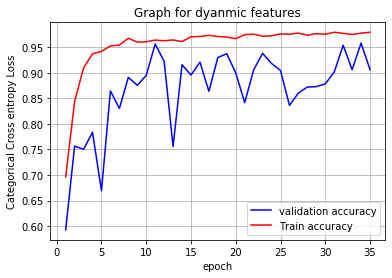

In [54]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.6))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_10 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1280)             

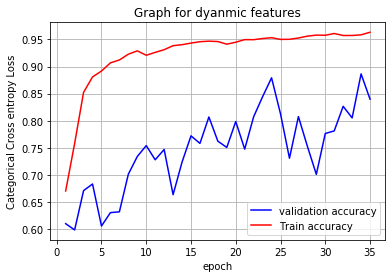

In [47]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.7))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.7))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_12 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1280)             

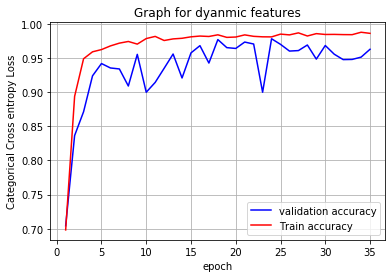

In [48]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.4))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.6))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

In [49]:

# fig, ax = plt.subplots(1, 1)
# ax.set_xlabel('epoch')
# ax.set_ylabel('Categorical Cross entropy Loss')

# x = list(range(1, 35+1))

# vy = history.history['val_acc']
# ty = history.history['acc']
# plt.title("Graph for dyanmic features")
# plt_dynamic(x, vy, ty, ax)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_14 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1280)            

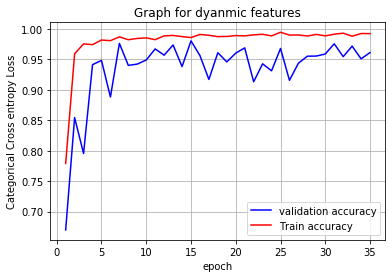

In [50]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.4))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.4))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_16 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 1280)            

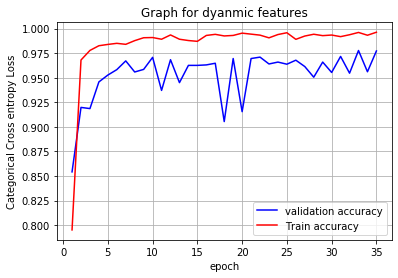

In [51]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.3))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.3))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_18 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 1280)            

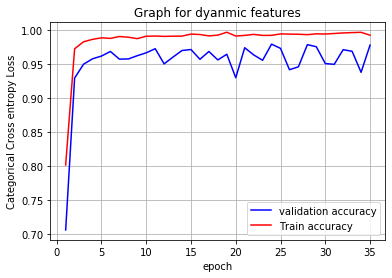

In [52]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.2))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.2))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_20 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
dense_2 (Dense)              (None, 64)              

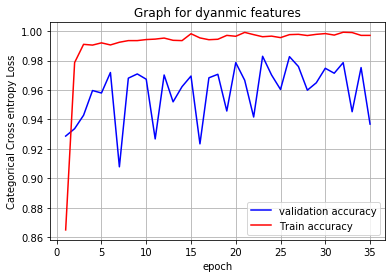

In [53]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2d.add(Dropout(0.2))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

# model_2d.add(Dropout(0.2))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(32, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(64, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_22 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_2 (Dense)              (None, 32)              

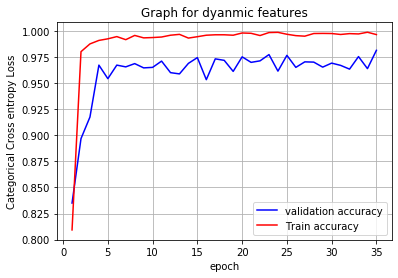

In [54]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2d.add(Dropout(0.2))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

# model_2d.add(Dropout(0.2))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

## We will continue with this model as it is giving accuracy more than 98%

In [55]:
import pickle
filename= "model_2d.pickle"
outfile = open(filename,'wb')
pickle.dump(model_2d,outfile)
outfile.close()

### Hyperparameter tune with static models

In [56]:
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(3, activation='softmax', name="dense_1"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=15)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_20 (Dropout)         (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 84675     
Total params: 197,891
Trainable params: 141,443
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 4071 samples, validate on 1559 samples
Epoch 1/15
4071/4071 [==============================] -

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 124, 5, 32)        9248      
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 122, 3, 32)        9248      
_________________________________________________________________
dropout_21 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 16)              

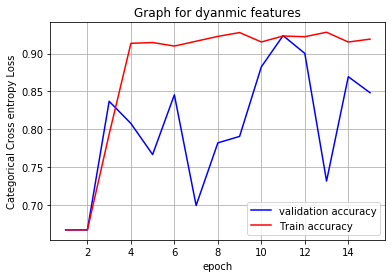

In [57]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer2",
                activation='sigmoid'))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer3",
                activation='sigmoid'))
# Adding a dropout layer
model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 124, 5, 32)        9248      
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 122, 3, 32)        9248      
_________________________________________________________________
flatten_16 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                187408    
_________________________________________________________________
dense_2 (Dense)              (None, 32)              

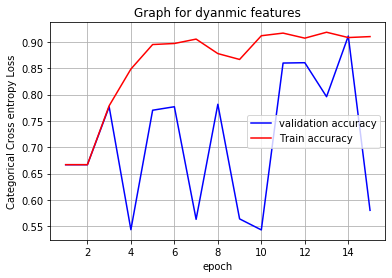

In [58]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer2",
                activation='sigmoid'))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer3",
                activation='sigmoid'))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 124, 5, 32)        9248      
_________________________________________________________________
flatten_17 (Flatten)         (None, 19840)             0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 19840)             79360     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                317456    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)               

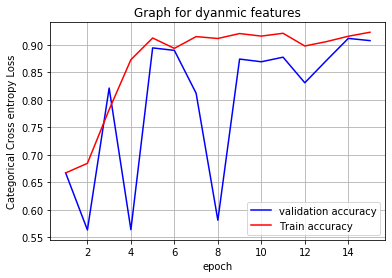

In [59]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer2",
                activation='sigmoid'))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
flatten_18 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                451600    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 565,459
Trainable params: 509,011
Non-trainable params: 56,448
__________________________________________

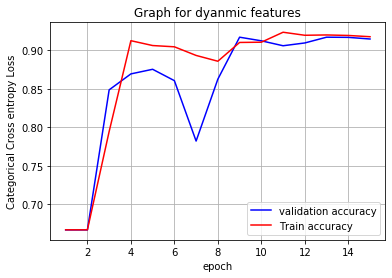

In [60]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
flatten_19 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                451600    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 565,459
Trainable params: 509,011
Non-trainable params: 56,448
__________________________________________

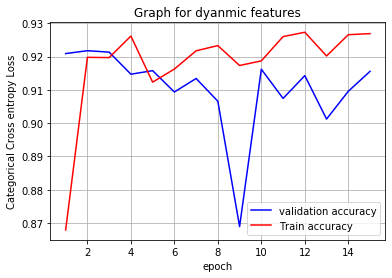

In [61]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
flatten_20 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                903200    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,017,571
Trainable params: 961,123
Non-trainable params: 56,448
________________________________________

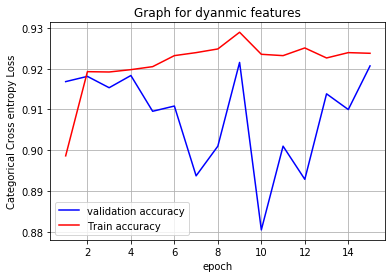

In [62]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 32)        832       
_________________________________________________________________
flatten_21 (Flatten)         (None, 19840)             0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 19840)             79360     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                634912    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 716,259
Trainable params: 676,579
Non-trainable params: 39,680
__________________________________________

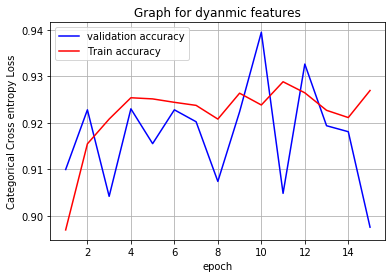

In [63]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
flatten_22 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                374816    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 424,419
Trainable params: 400,995
Non-trainable params: 23,424
__________________________________________

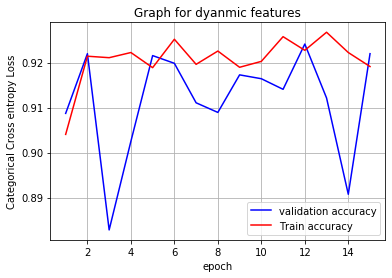

In [64]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
flatten_23 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                374816    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 424,419
Trainable params: 400,995
Non-trainable params: 23,424
__________________________________________

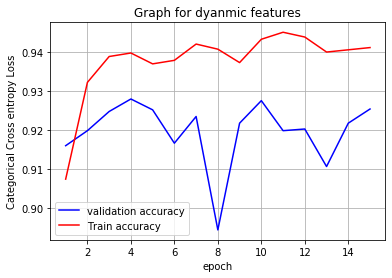

In [65]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
flatten_24 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                374816    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 424,419
Trainable params: 400,995
Non-trainable params: 23,424
__________________________________________

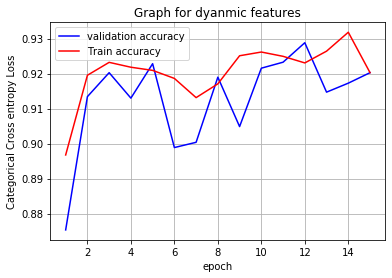

In [66]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='relu', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_35 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_2 (Dense)              (None, 32)              

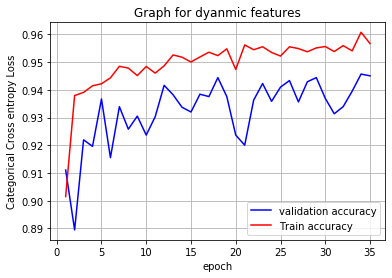

In [67]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

### Adding batch normalization in all different steps

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_37 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_39 (Batc (None, 32)              

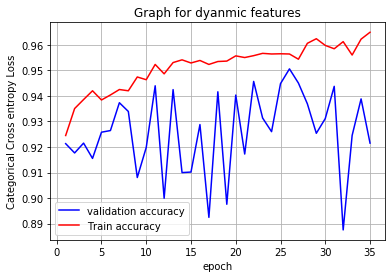

In [68]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_41 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_43 (Batc (None, 32)              

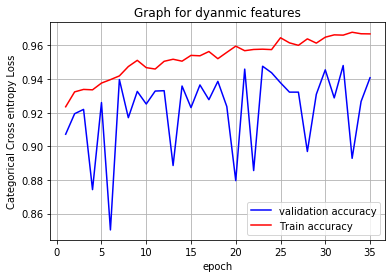

In [69]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_45 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_47 (Batc (None, 32)              

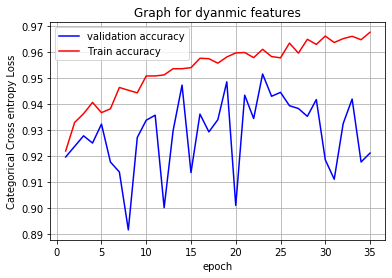

In [70]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='relu', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_49 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_51 (Batc (None, 32)              

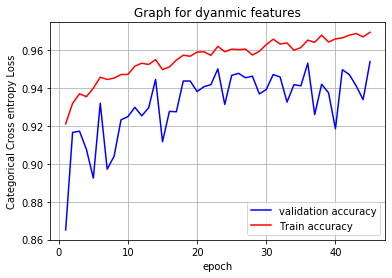

In [71]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='relu', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=45)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 45+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_53 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                61488     
_________________________________________________________________
batch_normalization_55 (Batc (None, 48)              

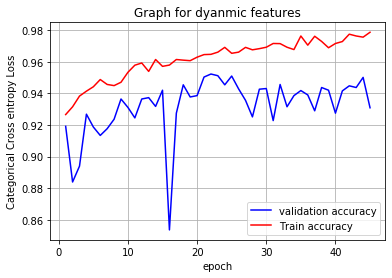

In [72]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=45)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 45+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_56 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)              

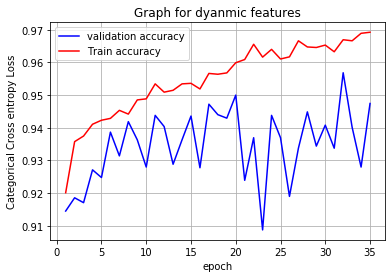

In [73]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_23 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 1280)            

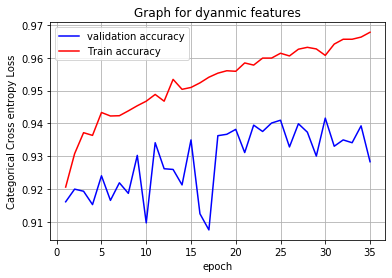

In [74]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_25 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 1280)            

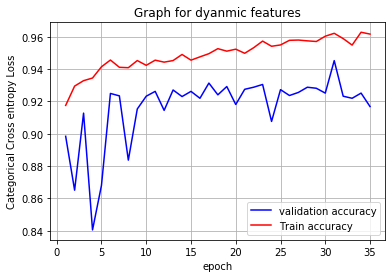

In [75]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2s.add(Dropout(0.3))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.3))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_65 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                61488     
_________________________________________________________________
batch_normalization_67 (Batc (None, 48)              

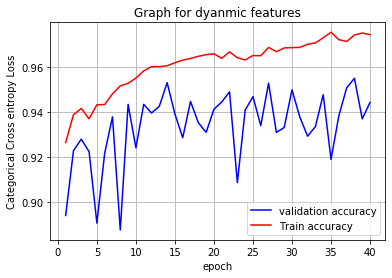

In [76]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=40)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 40+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

### Training a model which had 95 accuracy observedon 32 epoch.

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_68 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)              

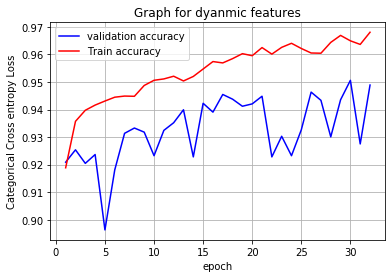

In [77]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=30)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 30+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

### Keeping this model as final model.

In [78]:
import pickle
# filename= "model_2d.pickle"
# outfile = open(filename,'wb')
# pickle.dump(model_2d,outfile)
# outfile.close()

filename= "model_2s.pickle"
outfile = open(filename,'wb')
pickle.dump(model_2s,outfile)
outfile.close()

## Now combining both the model to predict the values.

In [102]:
Y_train_hat = []
Y_train_hat.extend([val+1 for val in model_2d.predict_classes(np.array(X_train_new_d))])
Y_train_hat.extend([val+4 for val in model_2s.predict_classes(np.array(X_train_new_s))])

Y_test_hat = []
Y_test_hat.extend([val+1 for val in model_2d.predict_classes(np.array(X_test_new_d))])
Y_test_hat.extend([val+4 for val in model_2s.predict_classes(np.array(X_test_new_s))])

##############################################################



In [112]:
print(min(Y_train_hat))
print(max(Y_train_hat))

print(min(Y_test_hat))
print(max(Y_test_hat))


1
6
1
6


In [94]:
Y_train_grouped_train_d = []
Y_train_grouped_train_s = []

for ind, val in enumerate(y_hat_binary_train):
    if val[0] == 1:
#         X_test_new_d.append(X_test_new[ind])
        Y_train_grouped_train_d.append(np.argmax(list(Y_train[ind])))
#         if max(Y_test[ind][:3])==0: print("Misclassified index: ", ind)
    else:
#         X_test_new_s.append(X_test_new[ind])
        Y_train_grouped_train_s.append(np.argmax(list(Y_train[ind])))
#         if max(Y_test[ind][3:])==0: print("Misclassified index:", ind)
Y_train_grouped = []
Y_train_grouped.extend(Y_train_grouped_train_d)
Y_train_grouped.extend(Y_train_grouped_train_s)

#################################################################

Y_test_grouped_test_d = []
Y_test_grouped_test_s = []

for ind, val in enumerate(y_hat_binary_test):
    if val[0] == 1:
#         X_test_new_d.append(X_test_new[ind])
        Y_test_grouped_test_d.append(np.argmax(list(Y_test[ind])))
#         if max(Y_test[ind][:3])==0: print("Misclassified index: ", ind)
    else:
#         X_test_new_s.append(X_test_new[ind])
        Y_test_grouped_test_s.append(np.argmax(list(Y_test[ind])))
#         if max(Y_test[ind][3:])==0: print("Misclassified index:", ind)
Y_test_grouped = []
Y_test_grouped.extend(Y_test_grouped_test_d)
Y_test_grouped.extend(Y_test_grouped_test_s)

In [113]:
print(min(Y_train_grouped))
print(max(Y_train_grouped))

print(min(Y_test_grouped))
print(max(Y_test_grouped))


0
5
0
5


In [114]:
Y_train_grouped = [val+1 for val in Y_train_grouped]
Y_test_grouped = [val+1 for val in Y_test_grouped]


In [115]:
print(min(Y_train_grouped))
print(max(Y_train_grouped))

print(min(Y_test_grouped))
print(max(Y_test_grouped))


1
6
1
6


In [97]:
print(len(Y_train_grouped))
print(len(Y_test_grouped))

print(len(Y_train_hat))
print(len(Y_test_hat))


7352
2947
7352
2947


## Confusion Matrix for our classes

In [116]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_train_grouped, Y_train_hat))

[[1226    0    0    0    0    0]
 [   0 1069    0    2    2    0]
 [   0    0  986    0    0    0]
 [   0    0    0 1214   72    0]
 [   0    0    0  133 1241    0]
 [   0    0    0    0    0 1407]]


## Checking accuracy of our over all results

In [121]:
bad_pts = 0
for i in range(len(Y_train_grouped)):
#     print("true: ", Y_train_grouped[i], " ||hatvlaue: ", Y_train_hat[i])
    if Y_train_grouped[i] != Y_train_hat[i]:
        bad_pts+=1
false_pts= (bad_pts/len(Y_train_grouped))*100
print("Bad points percentage: ", false_pts)
print("Accuracy: ", 100-false_pts)

Bad points percentage:  2.8427638737758434
Accuracy:  97.15723612622416


# Here we are getting accuracy of 97% overall for data sets

In [ ]:
# import pickle
# # filename= "model_2d.pickle"
# # outfile = open(filename,'wb')
# # pickle.dump(model_2d,outfile)
# # outfile.close()

# filename= "model_2s.pickle"
# outfile = open(filename,'wb')
# pickle.dump(model_2s,outfile)
# outfile.close()